In [4]:
library(ggplot2)
library(igraph)
library(data.table)
library(magrittr)
psize = function(x=10,y=5) { options(repr.plot.width=x, repr.plot.height=y) } 

Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”
Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Warning message:
“package ‘data.table’ was built under R version 3.6.3”Warning message:
“package ‘magrittr’ was built under R version 3.6.3”

In [5]:
1+1

[1] 2

In [6]:
change_names <- function(dt, lookup, mycol="name"){
  # function to replace names of nodes, using a lookup table
  ## dt: data frame to change
  ## mycol: column in dt to change
  ## lookup table with 'old' and 'new' column, representing old and new names
  dt[, id:=1:nrow(dt)]
  dt <- merge(dt, lookup[,.(old, new)], by.x=mycol, by.y="old", all.x=T)
  dt <- dt[!is.na(new), as.character(mycol):=new][,new:=NULL]
  dt <- dt[order(id)]
  dt[,id:=NULL]
  return(dt)
}

In [7]:
covidgenes_negb = read.table("results/covid_net/edgelist/patient_meanSim.csv", sep=",", header=TRUE)
covidgenes_negb$node1 = gsub("GO:", "", covidgenes_negb$node1)
length(unique(covidgenes_negb$node1))

node_dict <- fread(file="../../../data/lookup/node_dict.txt");dim(node_dict); head(node_dict)
node_name_mapping = read.table("../../../data/lookup/node_name_mapping.txt", sep=",", header=TRUE)
covidgenes_negb <- change_names(as.data.table(covidgenes_negb), as.data.table(node_name_mapping), mycol="node2")
head(covidgenes_negb)


modalities = c("PRS_covid19Severe", "PRS_covid19", "PRS_covid19Hospitalization") 
c_genes <- covidgenes_negb[node2%in% modalities, node1]
table_for_graph  <- covidgenes_negb[node1 %in% c_genes]
table_for_graph <- merge(table_for_graph, node_dict[,.(new, type, color)], by.x="node2", by.y="new", all.x=T)

[1] 3082

[1] 7312    4

old,type,color,new
MHASTHMA,como,#C06C84,asthma
MHCOPD,como,#C06C84,COPD
MHCVD,como,#C06C84,cerebrovascularDiease
MHDPRSSN,como,#C06C84,majorDepression
MHHRTDIS,como,#C06C84,ischemicHeartDisease
MHHTN,como,#C06C84,hyptertension


node2,X,node1,neighbour,type_node1,type_node2,N,mean_sim,max_sim,sem_sim,source
Heart_Atrial_Appendage,0,A2M,1,gene,tissue,100,0.663943,0.741950,0.021931,patient
Brain_Frontal_Cortex_BA9,1,AAGAB,1,gene,tissue,81,0.711958,0.803277,0.051792,patient
Brain_Anterior_cingulate_cortex_BA24,2,AAK1,1,gene,tissue,100,0.757863,0.827443,0.034475,patient
Breast_Mammary_Tissue,3,AAK1,1,gene,tissue,100,0.668527,0.741021,0.039284,patient
Skin_Not_Sun_Exposed_Suprapubic,4,AAK1,1,gene,tissue,100,0.662176,0.722359,0.030489,patient
Brain_Cortex,5,AARS,1,gene,tissue,99,0.671847,0.733447,0.030849,patient


In [15]:
table_for_graph[node1=="MDC1"]


node2,X,node1,neighbour,type_node1,type_node2,N,mean_sim,max_sim,sem_sim,source,type,color
COPD,2636,MDC1,1,gene,como,100,0.718195,0.752655,0.018541,patient,como,#C06C84
PRS_bipolar,2639,MDC1,1,gene,prs,100,0.663587,0.726206,0.022701,patient,prs,#F67280
PRS_covid19Hospitalization,2637,MDC1,2,gene,prs,100,0.713502,0.744491,0.013795,patient,prs,#F67280
renalFailure,2638,MDC1,2,gene,como,100,0.686245,0.729036,0.018657,patient,como,#C06C84


first_genes <- fread("nikola-genes/first.txt", header=F)
colnames(first_genes) <- c("gene", "study")
covidgenes_negb <- merge(covidgenes_negb, first_genes, by.x="node1", by.y="gene") %>% setDT

In [6]:
working_dir = "data/covid_literature/new_knowing01"
pat_prot = fread(paste0(working_dir,'/annotate-out-kimonoGenes.PatientData-links.Lax-Proteins.simplified.txt'),col.names=c("gene", "study") )
pat_genes =  fread(paste0(working_dir,'/annotate-out-kimonoGenes.PatientData-links.Stringent-Genes.simplified.txt'),col.names=c("gene", "study") )
all_genes <- unique(rbind(pat_genes,pat_prot))

In [7]:
table_for_graph <- unique(merge(table_for_graph, all_genes, by.x="node1", by.y="gene"))
head(table_for_graph[,.N, by=.(node1, node2)][order(-N)][N>1])
x<-table_for_graph[,.N, by=.(node1, node2)][order(-N)][N>1][, unique(node1)]


node1,node2,N
ERBB2,PRS_covid19,2
ERBB2,PRS_covid19Hospitalization,2
ERBB2,PRS_covid19Severe,2
ERBB2,PRS_heartFailure,2
ERBB2,PRS_schizophrenia,2
ERBB2,renalFailure,2


In [8]:
table_for_graph[,source:=NULL]

table_for_graph[,source := study]
table_for_graph[node1%in%x,source :="Wu_P+Overmyer_KA"]
table_for_graph[,study:=NULL]
table_for_graph <- unique(table_for_graph)

In [9]:
table_for_graph$source %>% unique

[1] "Overmyer KA"      "Wu P"             "Wu_P+Overmyer_KA" "Alessandro A"    
[5] "Di B"

In [10]:
length(unique(table_for_graph$node1))
length(unique(table_for_graph$source))

[1] 47

[1] 5

In [11]:
graph_table <- unique(table_for_graph[,.(node1, source)])
pal <- c("#41729F", "#6997bf", "#C3E0E5", "#145DA0", "#2E8BC0")
pal <- c("#5885AF", "#607B8B", "#C3E0E5","#145DA0", "#2E8BC0")
graph_table$color = pal[as.numeric(as.factor(graph_table$source))]
graph_table[,frame_color:=color]


In [12]:
# make all genes one 145DA0:
graph_table[,color:="#2E8BC0"]
graph_table[,frame_color:="#2E8BC0"]

In [13]:
table_for_graph[grep("RNF", table_for_graph$node1)][,node1] %>% unique

table_for_graph[grep("PSM", table_for_graph$node1)][,.N, by=node2][order(-N)]

[1] "RNF8"

node2,N
PRS_covid19Severe,8
PRS_majorDepression,6
PRS_schizophrenia,6
PRS_crohnsDisease,5
PRS_covid19,4
Adipose_Subcutaneous,3
PRS_bipolar,3
PRS_heartFailure,3
PRS_smoking,3
PRS_CRP,3


In [14]:
toMatch <- c("RNF", "RPL", "RPS")


ribo <- unique (grep(paste(toMatch,collapse="|"), 
                        table_for_graph$node1, value=TRUE))
table_for_graph[node1%in%ribo][,.N, by=node2][order(-N)]

node2,N
PRS_covid19,9
PRS_heartFailure,8
PRS_majorDepression,7
PRS_obesity,6
PRS_crohnsDisease,5
PRS_psoriasis,5
PRS_schizophrenia,5
PRS_ADHD,5
PRS_coronaryArteryDisease,5
ischemicHeartDisease,5


In [15]:
table_for_graph[node1%in%c("PSMA4","PSMC1", "PSMC2")][,.N, by=node2][order(-N)]



node2,N
Adipose_Subcutaneous,3
PRS_covid19Severe,3
PRS_bipolar,2
PRS_crohnsDisease,2
PRS_heartFailure,2
PRS_majorDepression,2
PRS_schizophrenia,2
PRS_smoking,2
PRS_CRP,1
PRS_covid19,1


In [16]:
table_for_graph[,.N, by=.(node1)][order(-N)]

node1,N
RPS20,19
RPL27A,16
RPL21,15
GSTO1,13
PSMB1,13
PSMC2,11
HSP90AB1,10
RPL19,10
PSMA4,8
PTPN6,8


In [35]:
table_for_graph[type_node2=="tissue"][,.N, by=node2][order(-N)]

node2,N
Adipose_Subcutaneous,3
Brain_Putamen_basal_ganglia,1
Artery_Tibial,1


In [19]:
table_for_graph[,.N, by=.(node1,type_node2)][order(-N)]#[!type_node2=="prs"]

node1,type_node2,N
RPS20,prs,19
RPL27A,prs,15
RPL21,prs,12
GSTO1,prs,10
HSP90AB1,prs,10
PSMB1,prs,10
PSMC2,prs,9
RPL19,prs,9
SESN2,prs,8
PSMA4,prs,7


In [37]:
length(unique(graph_table$source))

[1] 5

In [38]:
psize = function(x=10,y=5) { options(repr.plot.width=x, repr.plot.height=y) } 

In [39]:
leg_dt <- unique(table_for_graph[,.(type, color)])
leg_dt[type=="como", type:="comorbidity"]
leg_dt[type=="prs", type:="PRS"]
#355C7D
leg_dt <- as.data.table(rbind(as.data.frame(leg_dt),c("gene", "#2E8BC0")))


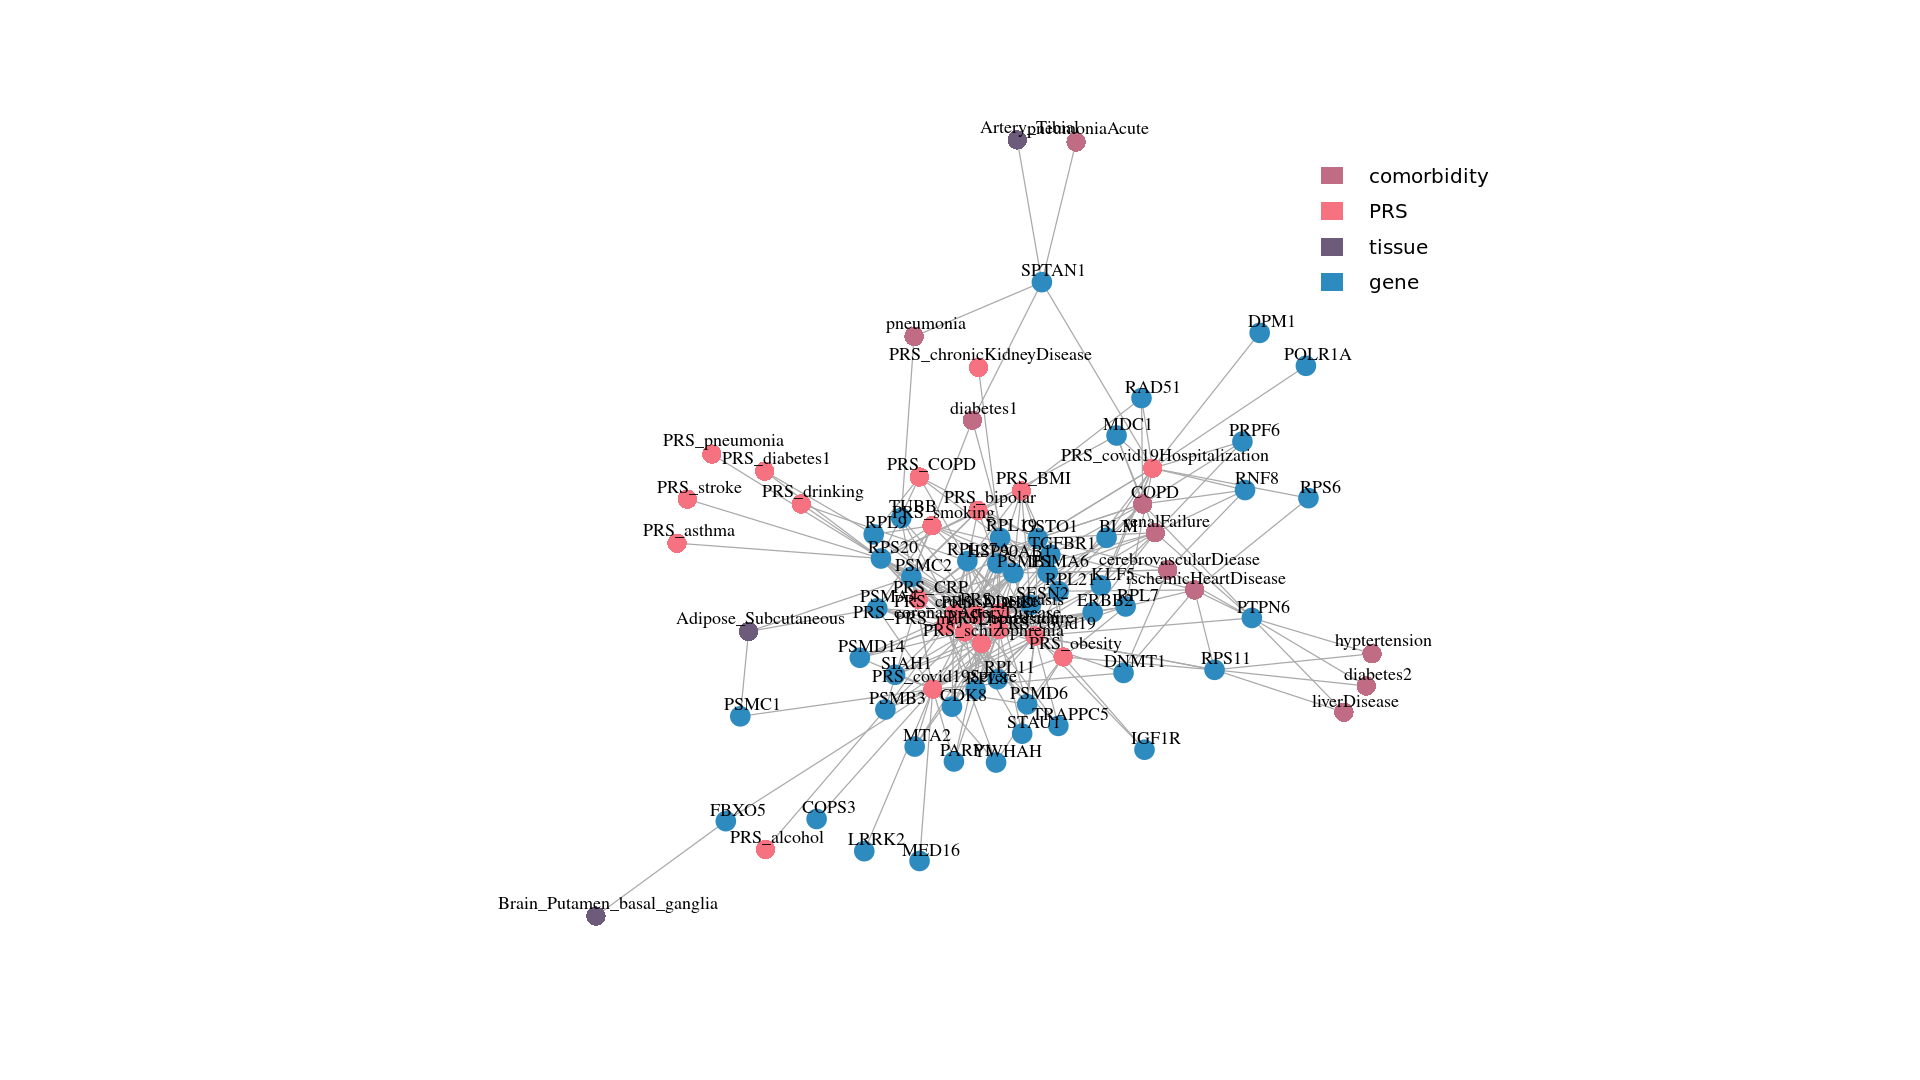

In [40]:
psize(16,9)

g = graph.empty(directed = F)

#g2 = graph.empty(directed = F)

g <- add.vertices(g,nv=length(graph_table$node1)
                  ,attr=list(name=graph_table$node1, color = graph_table$color,
                             frame.color=graph_table$frame_color)
                  ,type=rep(FALSE,length(graph_table$node1)))

dt_other <- unique(table_for_graph[,.(node2, type_node2, color)])
g <- add.vertices(g,nv=length(dt_other$node2),
                  attr=list(name=as.character(unique(dt_other$node2)), color=dt_other$color),
                  type=rep(TRUE,length(unique(dt_other$node2))))



edges1 = table_for_graph[, .(node1, node2)]
edge.list.vec_1 <- as.vector(t(as.matrix(data.frame(edges1))))


g <- add.edges(g,edge.list.vec_1)

lo = layout_nicely(g, dim = 2)

distances = c(0.6, 0.6)[V(g)$type + 1L]
plot(g, vertex.size = 5, vertex.label.cex = 0.9, vertex.label.color = "black",
        layout = lo,vertex.label.dist=distances)

legend(x = 0.8, y = 1, bty ='n', legend=unique(leg_dt$type), fill=unique(leg_dt$color), border=NA)
#legend(x = 0.9, y = 0.6, bty ='n', legend=unique(graph_table$source), fill=unique(graph_table$color), border=NA)


In [47]:
svg(file="results/fig3_covid_net/patient_genes_net_gene_col7.svg", width=18, height=18)
psize(16,9)

g = graph.empty(directed = F)

#g2 = graph.empty(directed = F)

g <- add.vertices(g,nv=length(graph_table$node1)
                  ,attr=list(name=graph_table$node1, color = graph_table$color,
                             frame.color=graph_table$frame_color)
                  ,type=rep(FALSE,length(graph_table$node1)))

dt_other <- unique(table_for_graph[,.(node2, type_node2, color)])
g <- add.vertices(g,nv=length(dt_other$node2),
                  attr=list(name=as.character(unique(dt_other$node2)), color=dt_other$color),
                  type=rep(TRUE,length(unique(dt_other$node2))))



edges1 = table_for_graph[, .(node1, node2)]
edge.list.vec_1 <- as.vector(t(as.matrix(data.frame(edges1))))


g <- add.edges(g,edge.list.vec_1)

lo = layout_nicely(g, dim = 2)

distances = c(0.6, 0.6)[V(g)$type + 1L]
plot(g, vertex.size = 2, vertex.label.cex = 0.9, vertex.label.color = "black",
        layout = lo,vertex.label.dist=distances)

legend(x = 0.8, y = 1, bty ='n', legend=unique(leg_dt$type), fill=unique(leg_dt$color), border=NA)
#legend(x = 0.9, y = 0.6, bty ='n', legend=unique(graph_table$source), fill=unique(graph_table$color), border=NA)

dev.off()

png 
  2

In [18]:
study="patient"
context <- covidgenes_negb[,.N, by=.(node2, type_node2)][order(-N)]
dt = context[type_node2=="pheno"] %>% dplyr::rename(node=node2, type=type_node2, count=N)
all=sum(dt$count)
dt[,ratio:=count/all]
fwrite(dt, file=paste0("results/fig3_supp_net_context/",study, "_pheno_dt.csv"))
dt=context[type_node2=="como"] %>% dplyr::rename(node=node2,  type=type_node2,count=N)
all=sum(dt$count)
dt[,ratio:=count/all]
fwrite(dt, file=paste0("results/fig3_supp_net_context/",study, "_como_dt.csv"))
dt=context[type_node2=="prs"] %>% dplyr::rename(node=node2,  type=type_node2,count=N)
all=sum(dt$count)
dt[,ratio:=count/all]
fwrite(dt, file=paste0("results/fig3_supp_net_context/",study, "_prs_dt.csv"))
dt=context[type_node2=="tissue"]%>% dplyr::rename(node=node2,  type=type_node2,count=N)
all=sum(dt$count)
dt[,ratio:=count/all]
fwrite(dt, file=paste0("results/fig3_supp_net_context/",study, "_tissue_dt.csv"))


gene_source=graph_table[,.(node1, source)] %>% dplyr::rename(gene=node1)
gene_source$source <- gsub("_", " ",gene_source$source)
fwrite(gene_source[order(gene)], file=paste0("results/fig3_supp_net_context/",study, "_gene_source.csv"))